In [1]:
import os
import numpy as np
import pandas as pd
import sklearn.datasets
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

from models import MLP
from data import load_2d_sample, load_gaussian_sample

In [3]:
def dsb_forward_rollout(encoder, data_sample, time_steps, step_size, data_t_embeddings = None, apply_encoder = True):
    
    if data_t_embeddings is None:
        num_data = data_sample.shape[0]
        t_embeddings = torch.arange(time_steps).reshape(-1, 1, 1).cuda() / time_steps
        data_t_embeddings = torch.repeat_interleave(t_embeddings, num_data, dim = 1)
    
    data_cache = []
    data_at_t = data_sample
    data_cache.append(data_at_t)
    for t in range(time_steps-1):
        if apply_encoder:
            data_at_t  = encoder(data_at_t, data_t_embeddings[t])
        else:
            data_at_t = data_at_t * (1 - step_size)
        data_at_t = data_at_t + np.sqrt(2*step_size) * torch.randn(*data_at_t.shape).cuda()
        data_cache.append(data_at_t)
        
    data_cache = torch.stack(data_cache, dim = 0)
    
    return data_cache

def dsb_backward_rollout(decoder, prior_sample, time_steps, step_size, prior_t_embeddings = None):
    
    if prior_t_embeddings is None:
        num_prior = prior_sample.shape[0]
        t_embeddings = torch.arange(time_steps).reshape(-1, 1, 1).cuda() / time_steps
        prior_t_embeddings = torch.repeat_interleave(t_embeddings, num_prior, dim = 1)
    
    prior_cache = []
    prior_at_t = prior_sample
    prior_cache.append(prior_at_t)
    for t in reversed(range(1, time_steps)):
        prior_at_t  = decoder(prior_at_t, prior_t_embeddings[t])
        prior_at_t = prior_at_t + np.sqrt(2*step_size) * torch.randn(*prior_at_t.shape).cuda()
        prior_cache.append(prior_at_t)
        
    prior_cache = prior_cache[::-1]
        
    prior_cache = torch.stack(prior_cache, dim = 0)
    
    return prior_cache

def dsb_train_decoder_one_step(
    encoder, decoder, 
    decoder_opt, 
    data_sample, 
    time_steps, step_size, 
    apply_encoder = True, 
):
    # sample shape: (batch, ...)
    
    num_data = data_sample.shape[0]
    
    t_embeddings = torch.arange(time_steps).reshape(-1, 1, 1).cuda() / time_steps
    
    data_t_embeddings = torch.repeat_interleave(t_embeddings, num_data, dim=1)
    
    encoder_opt.zero_grad()
    decoder_opt.zero_grad()
    
    ### Training decoder (forward function)
    
    data_cache = dsb_forward_rollout(encoder, data_sample, time_steps, step_size, data_t_embeddings)
    
    if apply_encoder:
        diff = decoder(data_cache[1:], data_t_embeddings[1:]) - (data_cache[1:] + encoder(data_cache[:-1], data_t_embeddings[:-1]) - encoder(data_cache[1:], data_t_embeddings[:-1]))
    else:
        diff = decoder(data_cache[1:-1], data_t_embeddings[1:-1]) - (data_cache[1:-1] + data_cache[1:-1] - data_cache[2:])
    decoder_loss = torch.square(diff).mean()
    
    decoder_loss.backward()
    # torch.nn.utils.clip_grad_norm_(decoder.parameters(), 0.5)
    decoder_opt.step()
    
    encoder_opt.zero_grad()
    decoder_opt.zero_grad()
    
    return decoder_loss.detach().cpu().numpy().item()

def dsb_train_encoder_one_step(
    encoder, decoder, 
    encoder_opt, 
    prior_sample, 
    time_steps, step_size, 
    bootstrap = True, 
):
    # sample shape: (batch, ...)
    
    num_prior = prior_sample.shape[0]
    
    t_embeddings = torch.arange(time_steps).reshape(-1, 1, 1).cuda() / time_steps
    
    prior_t_embeddings = torch.repeat_interleave(t_embeddings, num_prior, dim=1)
    
    encoder_opt.zero_grad()
    decoder_opt.zero_grad()
    
    ### Training encoder (backward function)
    
    prior_cache = dsb_backward_rollout(decoder, prior_sample, time_steps, step_size, prior_t_embeddings)

    diff = encoder(prior_cache[:-1], prior_t_embeddings[:-1]) - (prior_cache[:-1] + decoder(prior_cache[1:], prior_t_embeddings[1:]) - decoder(prior_cache[:-1], prior_t_embeddings[1:]))
    encoder_loss = torch.square(diff).mean()
    
    encoder_loss.backward()
    # torch.nn.utils.clip_grad_norm_(encoder.parameters(), 0.5)
    encoder_opt.step()
    
    encoder_opt.zero_grad()
    decoder_opt.zero_grad()
    
    return encoder_loss.detach().cpu().numpy().item()

In [4]:
### Hyperparameters

epochs = 20
iters_per_epoch = 2000
time_steps = 20

batch_size = 1024

lr = 1e-4

step_size = 1e-2

### Dataloader functions

load_data_sample = lambda: load_2d_sample(batch_size, name = "swiss_roll")
load_prior_sample = lambda: load_gaussian_sample((batch_size, 2))

### Initialize model

encoder = MLP(2, 1, 64, 4, step_size = step_size)
decoder = MLP(2, 1, 64, 4, step_size = step_size)

encoder.cuda()
decoder.cuda()

encoder_opt = optim.Adam(encoder.parameters(), lr=lr)
decoder_opt = optim.Adam(decoder.parameters(), lr=lr)

### Initiate training

pbar = tqdm(total = epochs, position=0, leave=True)

history = []
model_cache = []

train_log = {"decoder_loss": np.nan, "encoder_loss": np.nan}

for epoch in range(epochs):
    
    ### Train decoder until convergence
    for _ in range(iters_per_epoch):
        data_sample = load_data_sample().cuda()
        decoder_loss = dsb_train_decoder_one_step(
            encoder, decoder, 
            decoder_opt, 
            data_sample, 
            time_steps, step_size, 
            apply_encoder = (epoch != 0), # apply Langevin encoding process in the first iteration
        )
        train_log = {"decoder_loss": decoder_loss, "encoder_loss": np.nan}
        history.append(train_log)
        pbar.set_postfix(train_log)
    
    ### Train encoder until convergence
    for _ in range(iters_per_epoch):
        prior_sample = load_prior_sample().cuda()
        encoder_loss = dsb_train_encoder_one_step(
            encoder, decoder, 
            encoder_opt, 
            prior_sample, 
            time_steps, step_size, 
        )
        train_log = {"decoder_loss": np.nan, "encoder_loss": encoder_loss}
        history.append(train_log)
        pbar.set_postfix(train_log)
        
    model_cache.append((encoder, decoder))
    
    pbar.update(1)

  0%|          | 0/20 [00:00<?, ?it/s]

In [5]:
history_df = pd.DataFrame(history)

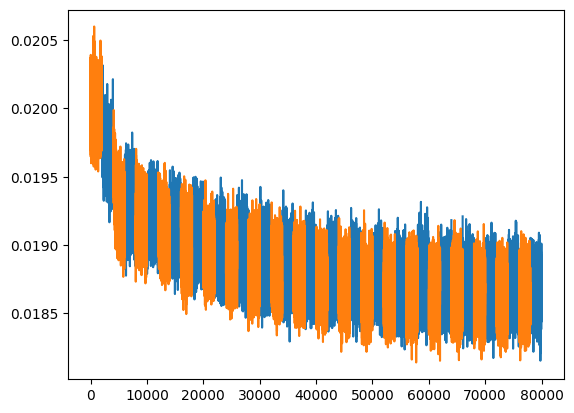

In [6]:
plt.plot(history_df["encoder_loss"])
plt.plot(history_df["decoder_loss"])
plt.show()

In [7]:
### evaluation rollout

_, decoder = model_cache[-1]

prior_sample = torch.randn(batch_size, 2).cuda()

cache = dsb_backward_rollout(decoder, prior_sample, time_steps, step_size)

cache = cache.detach().cpu().numpy()

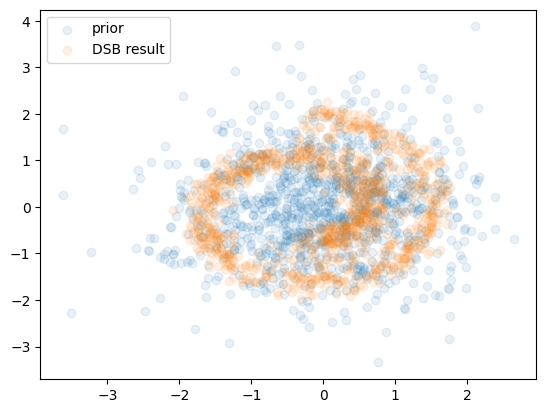

In [8]:
t = 0

data_sample = load_data_sample()

# plt.scatter(data_sample[:, 0].cpu(), data_sample[:, 1].cpu(), alpha = 0.1, label = "ground truth")
plt.scatter(cache[-1, :, 0], cache[-1, :, 1], alpha = 0.1, label = "prior")
plt.scatter(cache[t, :, 0], cache[t, :, 1], alpha = 0.1, label = "DSB result")

plt.legend()

plt.show()

In [10]:
from datetime import datetime

now = datetime.now()
hour = now.hour
minute = now.minute

torch.save([(e.state_dict(), d.state_dict()) for (e,d) in model_cache], "dsb_models_{}{}.pt".format(hour, minute))